In [ ]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import os 
import zipfile

In [2]:
## Unzip data if needed 

# Define paths for each zip file
zip_files = {
    "dataset": "FullDataset/bondugula_JDO_20230125_SLIM.csv.zip",
    "notebook1": "FullDataset/full-data-nb.ipynb.zip",
    "notebook2": "FullDataset/full-data-practice-041223.ipynb.zip",
    "notebook3": "FullDataset/full-data-practice-061023.ipynb.zip",
    "notebook4": "FullDataset/full-data-practice-20230225.ipynb.zip",
    "unknown_csv": "FullDataset/s8-acetyl+sirt-output.csv.zip"
}

# Function to unzip files
def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted {zip_path} to {extract_to}")

# Directory to extract all files
extract_dir = "Unzipped_Files"

if not os.path.exists(extract_dir):
    # Only execute this block if extract_dir does not exist
    os.makedirs(extract_dir, exist_ok=True)

    # Unzip each file
    for name, path in zip_files.items():
        output_folder = os.path.join(extract_dir, name)  # Folder based on each file's label
        os.makedirs(output_folder, exist_ok=True)
        unzip_file(path, output_folder)
    print("Extraction Complete!")
else:
    print("Extraction directory already exists. No files were extracted.")

Extraction directory already exists. No files were extracted.


# View dataset

This is from the supplementary material document in Jonathans paper: 

To obtain the possible secondary structure input values required to calculate Vkabat, the FASTA sequence was input to the fifteen following algorithms: GOR1, GOR3, DPM, PREDATOR, HNNC, SOPM, MLRC, DSC, JPRED, PHD, PROF, SSPRO, YASPIN, JNET, and PSIPRED [3,10]. From this output, we calculated Vkabat for each residue.

This implies that we should not use those columns 

In [3]:
# Define path to data and define it
file_path = "Unzipped_Files/dataset/bondugula_JDO_20230125_SLIM.csv"
data = pd.read_csv(file_path, index_col=0)

# View data
print(data.columns)
data.head(5)

Index(['Residue', 'E6', 'E20', 'Protein', 'No.', 'Res', 'isUnstruct', 'E6.1',
       'E20.1', 'E22', 'Vkbat', 'chou_fasman', 'sspro_5', 'gor4', 'dsc',
       'jnet', 'psipred', '# homologues', 'HAS_H', 'HAS_S', 'HAS_O', 'HAS_U',
       'ProteinID'],
      dtype='object')


,Residue,E6,E20,Protein,No.,Res,isUnstruct,E6.1,E20.1,E22,...,gor4,dsc,jnet,psipred,# homologues,HAS_H,HAS_S,HAS_O,HAS_U,ProteinID
0,D,0.926212,0.926212,2BDE,1,D,0.954544,NaN,NaN,NaN,...,Other,Other,Other,Other,6,0,0,0,1,2BDE_0
1,T,1.307625,2.024379,2BDE,2,T,0.805483,NaN,NaN,NaN,...,Other,Other,Other,Other,6,0,0,0,1,2BDE_0
2,H,1.321518,1.668090,2BDE,3,H,0.654102,NaN,NaN,NaN,...,Other,Other,Other,Helix,6,0,0,0,1,2BDE_0
3,K,0.528085,0.845275,2BDE,4,K,0.501600,NaN,NaN,NaN,...,Other,Other,Other,Helix,6,0,0,1,1,2BDE_0
4,V,0.000000,0.583619,2BDE,5,V,0.280561,NaN,NaN,NaN,...,Sheet,Sheet,Sheet,Helix,6,0,1,0,1,2BDE_0


In [4]:
for col in data.columns: 
    print(data[col].value_counts())

Residue
L    104325
A     89128
V     78339
G     78022
E     76740
I     63794
K     63438
D     63235
S     62704
R     58134
T     58127
P     50466
N     44861
F     44731
Q     40570
Y     37917
H     25411
M     24259
W     15017
C     14052
X        14
U         2
Name: count, dtype: int64
E6
0.000000    320144
0.011408     47089
0.020814     14585
0.022814     10790
0.032219      7273
             ...  
0.534911         1
1.529886         1
0.834279         1
0.731576         1
1.138646         1
Name: count, Length: 400798, dtype: int64
E20
0.000000    199512
0.011408     42491
0.022814     16578
0.020814     10321
0.032219      8905
             ...  
0.302906         1
1.455480         1
1.567710         1
0.812933         1
1.968575         1
Name: count, Length: 549849, dtype: int64
Protein
1SMY    2951
1W36    2819
2FUG    2357
1N62    2341
1Y5I    2185
        ... 
2BI6      22
1K91      21
1J5J      21
1OC0      19
1OQE      16
Name: count, Length: 4399, dtype: int64
No

In [5]:
print(data.iloc[1, :])

Residue                T
E6              1.307625
E20             2.024379
Protein             2BDE
No.                    2
Res                    T
isUnstruct      0.805483
E6.1                 NaN
E20.1                NaN
E22                  NaN
Vkbat                2.4
chou_fasman        Sheet
sspro_5            Other
gor4               Other
dsc                Other
jnet               Other
psipred            Other
# homologues           6
HAS_H                  0
HAS_S                  0
HAS_O                  0
HAS_U                  1
ProteinID         2BDE_0
Name: 1, dtype: object


In [6]:
numeric_data = data[["E6", "E20", "isUnstruct", "Vkbat"]]

numeric_data.corr()

,E6,E20,isUnstruct,Vkbat
E6,1.000000,0.908737,0.078586,-0.009384
E20,0.908737,1.000000,0.056172,-0.001326
isUnstruct,0.078586,0.056172,1.000000,-0.101881
Vkbat,-0.009384,-0.001326,-0.101881,1.000000


We know the significant descriptors are:

**Homology Descriptors:**
* E6 (6 term sequence entropy)
* isUnstruct (Disorder Propensity)
> Algorithmn used to predict the propensity of a residue from sequence to be disordered (Lobanov & Galzitskaya, 2011)
* Vkabat (Secondary Structure Variability)
> Used to describe variability of regions on antibodies (Wu & Kabat, 1970; Valdar, 2020)

From Nepal et al: 
* E20 (20 term sequence entropy)
> This descriptor has been named inferior to E6. Use E6 instead (Nepal et al, 2015). Also explains the higher correlation.
* Utilized AA creating 19 dummy variables

From Google:
'chou_fasman', 'sspro_5', 'gor4', 'dsc', 'jnet', 'psipred' are all different algorithmns for secondary protein structure prediction. 
Target:
* The target that we need to define is the switch. This occurs when HAS_H, HAS_S, HAS_O, HAS_U added together is greater than 1. We need to make this column

In [7]:
# Create a copy dataframe of region of interest 
switch_det = data.iloc[:, -5:-1]

# Define new column that detects the switch occuring 
switch_det['switch'] = (switch_det.sum(axis=1) > 1).astype(int) # Create binar column, True = 1 and False = 0

# Print values
switch_det.head(3)

,HAS_H,HAS_S,HAS_O,HAS_U,switch
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0


In [8]:
print(switch_det['switch'].value_counts())

switch
0    914237
1    179049
Name: count, dtype: int64


In [9]:
# Add our switch column to the main one 
data2 = data.copy()

data2 = pd.concat([data2, switch_det['switch']], axis=1)
data2.head(5)

,Residue,E6,E20,Protein,No.,Res,isUnstruct,E6.1,E20.1,E22,...,dsc,jnet,psipred,# homologues,HAS_H,HAS_S,HAS_O,HAS_U,ProteinID,switch
0,D,0.926212,0.926212,2BDE,1,D,0.954544,NaN,NaN,NaN,...,Other,Other,Other,6,0,0,0,1,2BDE_0,0
1,T,1.307625,2.024379,2BDE,2,T,0.805483,NaN,NaN,NaN,...,Other,Other,Other,6,0,0,0,1,2BDE_0,0
2,H,1.321518,1.668090,2BDE,3,H,0.654102,NaN,NaN,NaN,...,Other,Other,Helix,6,0,0,0,1,2BDE_0,0
3,K,0.528085,0.845275,2BDE,4,K,0.501600,NaN,NaN,NaN,...,Other,Other,Helix,6,0,0,1,1,2BDE_0,1
4,V,0.000000,0.583619,2BDE,5,V,0.280561,NaN,NaN,NaN,...,Sheet,Sheet,Helix,6,0,1,0,1,2BDE_0,1


# Data Pre-Processing

## Lets check our columns have valid data

In [10]:
# See if there is any missing values 
print("Missing data:")
print(data2.isnull().sum())

Missing data:
Residue               0
E6                 3710
E20                3710
Protein               0
No.                   0
Res                   0
isUnstruct            0
E6.1            1093286
E20.1           1093286
E22             1093286
Vkbat                 0
chou_fasman           0
sspro_5               0
gor4                  0
dsc                   0
jnet                  0
psipred               0
# homologues          0
HAS_H                 0
HAS_S                 0
HAS_O                 0
HAS_U                 0
ProteinID             0
switch                0
dtype: int64


Based off Jonathan's notebook E6.1, E20.1, E22 are not used at all. We can drop these. As far as the 3710 entries missing we can drop those rows as well.

In [11]:
# Drop those missing data values
data2.drop(columns=['E6.1', 'E20.1', 'E22'], inplace=True)
data2.dropna(inplace=True)

# Normalize data 

In [12]:
# View data descriptive stats
data2.describe()

,E6,E20,No.,isUnstruct,Vkbat,# homologues,HAS_H,HAS_S,HAS_O,HAS_U,switch
count,1.089576e+06,1.089576e+06,1.089576e+06,1.089576e+06,1.089576e+06,1.089576e+06,1.089576e+06,1.089576e+06,1.089576e+06,1.089576e+06,1.089576e+06
mean,4.613143e-01,7.981048e-01,1.800823e+02,2.363689e-01,2.752236e+00,1.674654e+01,4.094391e-01,2.390545e-01,2.641165e-01,2.677060e-01,1.638463e-01
std,6.268500e-01,9.191382e-01,1.657662e+02,2.300717e-01,1.629132e+00,3.857491e+01,4.917306e-01,4.265063e-01,4.408618e-01,4.427637e-01,3.701362e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,5.706888e-04,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.083201e-02,6.200000e+01,6.579392e-02,1.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.079314e-02,3.989436e-01,1.340000e+02,1.516327e-01,2.400000e+00,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.515738e-01,1.383933e+00,2.480000e+02,3.318337e-01,3.000000e+00,1.500000e+01,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
max,2.581541e+00,4.207811e+00,1.505000e+03,1.000000e+00,9.000000e+00,1.174000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


As expected all different scales. We need to scale the data so its on a normal distribution. We also need to One Hot encode all the categorical data

In [13]:
# Initialize Standard Scaler 
scaler = StandardScaler()

# Seperate features from target 
data_quantitative = data2[["E6", 'E20', "isUnstruct", "Vkbat"]]

# Fit and transform data 
standardized_data = scaler.fit_transform(data_quantitative)

# Convert to dataframe
standardized_df = pd.DataFrame(standardized_data, columns=data_quantitative.columns, index=data2.index)
standardized_df.head(3)

,E6,E20,isUnstruct,Vkbat
0,0.741642,0.139378,3.121528,-1.075564
1,1.350102,1.334157,2.473639,-0.216211
2,1.372264,0.946523,1.815667,1.072820


In [14]:
# Remember that we need to drop E20 as its highly correlated with E6 and E6 was determiend a better descriptor
standardized_df.drop(columns=["E20"], inplace=True)

## One Hot Encode categorical data (Qualitative features)

The categorical data that Jonathan used were 'chou_fasman', 'sspro_5', 'gor4', 'dsc', 'jnet', 'psipred'

In [15]:
print(data2['chou_fasman'].unique())
print(data2['sspro_5'].unique())
print(data2['gor4'].unique())
print(data2['dsc'].unique())
print(data2['jnet'].unique())
print(data2['psipred'].unique())

['Other' 'Sheet' 'Helix']
['Other' 'Sheet' 'Helix']
['Other' 'Sheet' 'Helix']
['Other' 'Sheet' 'Helix']
['Other' 'Sheet' 'Helix']
['Other' 'Helix' 'Sheet']


In [16]:
# Initialize One Hot Encoder
ohe = OneHotEncoder(
    drop=['Other', 'Other', 'Other', 'Other', 'Other', 'Other']
)

# Encode categorical data
ohe_features_array = ohe.fit_transform(data2[['chou_fasman', 'sspro_5', 'gor4', 'dsc', 'jnet', 'psipred']]).toarray()

# View result
print(ohe_features_array)
print(len(ohe_features_array))

feature_labels = ohe.categories_
print(feature_labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1089576
[array(['Helix', 'Other', 'Sheet'], dtype=object), array(['Helix', 'Other', 'Sheet'], dtype=object), array(['Helix', 'Other', 'Sheet'], dtype=object), array(['Helix', 'Other', 'Sheet'], dtype=object), array(['Helix', 'Other', 'Sheet'], dtype=object), array(['Helix', 'Other', 'Sheet'], dtype=object)]


In [17]:
feature_labels = ohe.get_feature_names_out(['chou_fasman', 'sspro_5', 'gor4', 'dsc', 'jnet', 'psipred'])
print(feature_labels)

['chou_fasman_Helix' 'chou_fasman_Sheet' 'sspro_5_Helix' 'sspro_5_Sheet'
 'gor4_Helix' 'gor4_Sheet' 'dsc_Helix' 'dsc_Sheet' 'jnet_Helix'
 'jnet_Sheet' 'psipred_Helix' 'psipred_Sheet']


In [18]:
ohe_df = pd.DataFrame(ohe_features_array, columns=feature_labels, index=data2.index)
ohe_df.head(3)

,chou_fasman_Helix,chou_fasman_Sheet,sspro_5_Helix,sspro_5_Sheet,gor4_Helix,gor4_Sheet,dsc_Helix,dsc_Sheet,jnet_Helix,jnet_Sheet,psipred_Helix,psipred_Sheet
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Convert Oridanal to Numeric and scale it

In [19]:
# Initialize Ordinal encoder
ord = OrdinalEncoder()

# Encode Ordinal data which is Residue
ord_features_array = ord.fit_transform(data2[["Residue"]])

# View result
print(ord_features_array)
print(len(ord_features_array))

feature_labels_ord = ord.categories_
print(feature_labels_ord)

[[ 2.]
 [16.]
 [ 6.]
 ...
 [12.]
 [ 0.]
 [ 0.]]
1089576
[array(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y'], dtype=object)]


In [20]:
feature_labels_ord = ord.get_feature_names_out(["Residue"])
print(feature_labels_ord)

['Residue']


In [21]:
ord_df = pd.DataFrame(ord_features_array, columns=feature_labels_ord, index=data2.index)
ord_df.head(3)

,Residue
0,2.0
1,16.0
2,6.0


In [22]:
### Another oridinal column is the # of Homologues. Its already in numeric format we just need to scale it.
# ord_data = pd.concat([ord_df, data2["# homologues"]], axis=1)
# print(ord_data.isnull().sum())
ord_data = ord_df

# Scale ordinal data 
ord_standard = scaler.fit_transform(ord_data)

# Convert to dataframe
standardized_ord_df = pd.DataFrame(ord_standard, columns=ord_data.columns, index=data2.index)
standardized_ord_df.head(3)


,Residue
0,-1.216395
1,1.157032
2,-0.538273


### Merge all preprocessing and drop columns we no longer need for Modeling

In [23]:
# Merge all the preprocessed data and target 
merged_df = pd.concat([standardized_df, standardized_ord_df, data2['switch']], axis=1)
merged_df.head(3)

,E6,isUnstruct,Vkbat,Residue,switch
0,0.741642,3.121528,-1.075564,-1.216395,0
1,1.350102,2.473639,-0.216211,1.157032,0
2,1.372264,1.815667,1.072820,-0.538273,0


In [24]:
print(merged_df.columns)

Index(['E6', 'isUnstruct', 'Vkbat', 'Residue', 'switch'], dtype='object')


# Modeling Quantitative with Qualitative Descriptors

In [25]:
# Define features and target
X = merged_df.iloc[:, :-1]
y = merged_df.iloc[:, -1]

# Add intercept for modeling purposes
X = sm.add_constant(X)

# Create Train test split based on features and target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42, shuffle=True)

## Logit Classifier

In [26]:
# Create Logistic model
model = sm.Logit(y_train, X_train)
result = model.fit()

# Review summary of training
print(result.summary())
print()

Optimization terminated successfully.
         Current function value: 0.442507
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 switch   No. Observations:               871660
Model:                          Logit   Df Residuals:                   871655
Method:                           MLE   Df Model:                            4
Date:                Fri, 15 Nov 2024   Pseudo R-squ.:                0.007628
Time:                        13:46:20   Log-Likelihood:            -3.8572e+05
converged:                       True   LL-Null:                   -3.8868e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6457      0.003   -561.371      0.000      -1.651      -1.640
E6             0.0127      0.

In [27]:
# Predict probabilities for the test data and train data
y_pred_prob_test = result.predict(X_test)
y_pred_prob_train = result.predict(X_train)

# Convert probabilities to binary predictions (0 or 1)
y_pred_test = (y_pred_prob_test > 0.5).astype(int)  # Using 0.5 as the threshold for now
y_pred_train = (y_pred_prob_train > 0.5).astype(int)

# Compare predicted values to actual values
acc_test = accuracy_score(y_test, y_pred_test)
acc_train = accuracy_score(y_train, y_pred_train)

print(f"Accuracy Train: {acc_train:.4f}")
print(f"Accuracy Test: {acc_test:.4f}")

Accuracy Train: 0.8362
Accuracy Test: 0.8359


In [28]:
from sklearn.metrics import confusion_matrix
# Create sensitivity and specificity calc
def sens_spec_calc(y_pred, y_true):
    # Create confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calc Sens and Spec
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    
    print("Sensitivity:", sens)
    print("Specificity:", spec)

print("Training:")
sens_spec_calc(y_pred=y_pred_train, y_true=y_train)
print("Testing:")
sens_spec_calc(y_pred=y_pred_test, y_true=y_test)

Training:
Sensitivity: 0.0
Specificity: 1.0
Testing:
Sensitivity: 0.0
Specificity: 1.0


We can see how the model is not overfitting the data at all. The train and testing sets are nearly identical performances. Let see if an OLS model can do better.

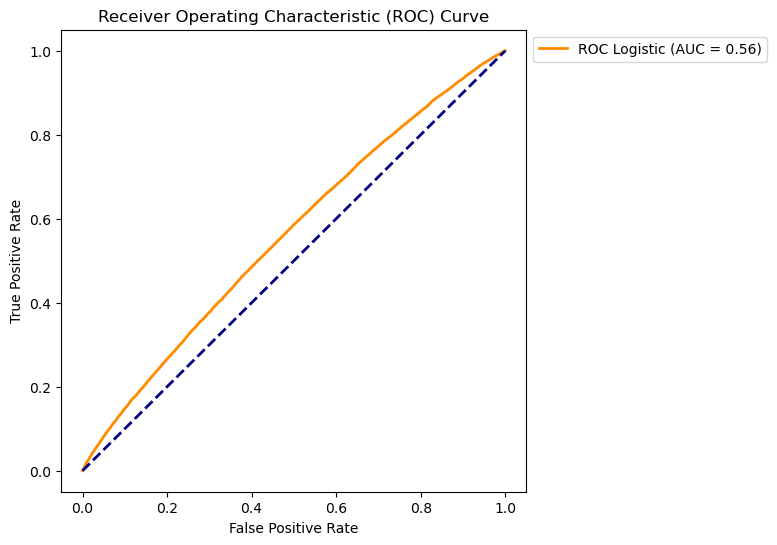

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score

# Make ROC curve 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_test)
roc_auc = roc_auc_score(y_test, y_pred_prob_test)

plt.figure(figsize=(6,6), facecolor='white')
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Logistic (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

## OLS Model

In [30]:
# Create OLS model 
ols = sm.OLS(y_train, X_train)

# Obtain result
ols_result = ols.fit()

# Print summary 
print(ols_result.summary())
print()

                            OLS Regression Results                            
Dep. Variable:                 switch   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1558.
Date:                Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                        13:46:21   Log-Likelihood:            -3.6729e+05
No. Observations:              871660   AIC:                         7.346e+05
Df Residuals:                  871655   BIC:                         7.346e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1638      0.000    414.731      0.0

# Explore Ensemble Models

The models do not perform that well in general. The ROC curve for the Logistic is not great. Perhaps we need a more complex model here. 

In [ ]:
# Create exploration
# Define the models and their parameters
random_state = 42

models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=random_state),
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=random_state),
    },
    'Support Vector Machine': {
        'model': SVC(random_state=random_state),
    },
    'Naive Bayes': {
        'model': GaussianNB(random_state=random_state),
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=random_state),
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=random_state),
    }
}

# Iterate over models and evaluate
best_models = {}

for model_name, config in models.items():
    print(f"Training {model_name}...")
    
    # Create a pipeline
    pipeline = Pipeline([
        ('model', config['model'])    # The model
    ])
    
    # Perform grid search
    grid = GridSearchCV(pipeline, config['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    # Save the best model and its score
    best_models[model_name] = {
        'best_estimator': grid.best_estimator_,
        'best_params': grid.best_params_,
        'best_score': grid.best_score_
    }
    print(f"{model_name} Best Score: {grid.best_score_}")

# Print summary of results
print("\nSummary of Results:")
for model_name, results in best_models.items():
    print(f"{model_name}: Best Score = {results['best_score']:.4f}")